In [1]:
import numpy as np
from copy import copy
from six import iteritems
from matplotlib import pyplot as plt
from pygenn import genn_model, genn_wrapper

In [2]:
# Load MNIST data (pre-normalized and coverted to numpy format)
training_images = np.load("training_images.npy")
training_labels = np.load("training_labels.npy")

### Visualize training data

(60000, 784)


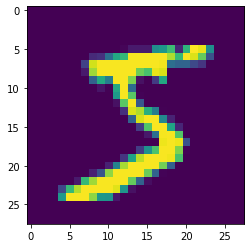

In [3]:
print(training_images.shape)
assert np.allclose(np.sum(training_images, axis=1), 1.0)

fig, axis = plt.subplots()
axis.imshow(np.reshape(training_images[0], (28, 28)))

### Parameters

In [4]:
DT = 0.1
INPUT_SCALE = 80.0
NUM_PN = 784
NUM_MBON = 10
NUM_KC = 20000
PRESENT_TIME_MS = 20.0

# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}

# We only want PNs to spike once
PN_PARAMS = copy(LIF_PARAMS)
PN_PARAMS["TauRefrac"] = 100.0

# We will use weights of 1.0 for KC->GGN connections and  
# want the GGN to inhibit the KCs after 200 spikes
GGN_PARAMS = {
    "Vthresh": 200.0}

MBON_STIMULUS_CURRENT = 5.0

PN_KC_WEIGHT = 0.2
PN_KC_TAU_SYN = 3.0
PN_KC_FAN_IN = 20

KC_MBON_TAU_SYN = 3.0
KC_MBON_PARAMS = {"tau": 15.0,
                  "rho": 0.18,
                  "eta": 0.00002,
                  "wMin": 0.0,
                  "wMax": 0.0233}


### Custom models

In [5]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = genn_model.create_custom_current_source_class(
    "cs_model",
    var_name_types=[("magnitude", "scalar")],
    injection_code="$(injectCurrent, $(magnitude));")

# Minimal integrate and fire neuron model
if_model = genn_model.create_custom_neuron_class(
    "IF",
    param_names=["Vthresh"],
    var_name_types=[("V", "scalar")],
    sim_code=
    """
    $(V)+= $(Isyn);
    """,
    threshold_condition_code=
    """
    $(V) >= $(Vthresh)
    """,
    reset_code=
    """
    $(V)= 0.0;
    """)

# STDP synapse with additive weight dependence
symmetric_stdp = genn_model.create_custom_weight_update_class(
    "symmetric_stdp",
    param_names=["tau", "rho", "eta", "wMin", "wMax"],
    var_name_types=[("g", "scalar")],
    sim_code=
    """
    const scalar dt = $(t) - $(sT_post);
    const scalar timing = exp(-dt / $(tau)) - $(rho);
    const scalar newWeight = $(g) + ($(eta) * timing);
    $(g) = fmin($(wMax), fmax($(wMin), newWeight));
    """,
    learn_post_code=
    """
    const scalar dt = $(t) - $(sT_pre);
    const scalar timing = fmax(exp(-dt / $(tau)) - $(rho), -0.1*$(rho));
    const scalar newWeight = $(g) + ($(eta) * timing);
    $(g) = fmin($(wMax), fmax($(wMin), newWeight));
    """,
    is_pre_spike_time_required=True,
    is_post_spike_time_required=True)

### Model definition

In [6]:
# Create model
model = genn_model.GeNNModel("float", "mnist_mb")
model.dT = DT
model._model.set_seed(1337)

# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
if_init = {"V": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)
kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)
ggn = model.add_neuron_population("ggn", 1, if_model, GGN_PARAMS, if_init)
mbon = model.add_neuron_population("mbon", NUM_MBON, "LIF", LIF_PARAMS, lif_init)

# Turn on spike recording
pn.spike_recording_enabled = True
kc.spike_recording_enabled = True
mbon.spike_recording_enabled = True

# Create current sources to deliver input and supervision to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})
mbon_input = model.add_current_source("mbon_input", cs_model, mbon , {}, {"magnitude": 0.0})

# Create synapse populations
pn_kc = model.add_synapse_population("pn_kc", "SPARSE_GLOBALG", genn_wrapper.NO_DELAY,
                                     pn, kc,
                                     "StaticPulse", {}, {"g": PN_KC_WEIGHT}, {}, {},
                                     "ExpCurr", {"tau": PN_KC_TAU_SYN}, {},
                                     genn_model.init_connectivity("FixedNumberPreWithReplacement", {"colLength": PN_KC_FAN_IN}))

kc_ggn = model.add_synapse_population("kc_ggn", "DENSE_GLOBALG", genn_wrapper.NO_DELAY, 
                                      kc, ggn, 
                                      "StaticPulse", {}, {"g": 1.0}, {}, {}, 
                                      "DeltaCurr", {}, {})

ggn_kc = model.add_synapse_population("ggn_kc", "DENSE_GLOBALG", genn_wrapper.NO_DELAY, 
                                      ggn, kc,
                                      "StaticPulse", {}, {"g": -5.0}, {}, {}, 
                                      "ExpCurr", {"tau": 5.0}, {})

kc_mbon = model.add_synapse_population("kc_mbon", "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
                                       kc, mbon,
                                       symmetric_stdp, KC_MBON_PARAMS, {"g": np.zeros(NUM_KC*NUM_MBON)}, {}, {},
                                       "ExpCurr", {"tau": KC_MBON_TAU_SYN}, {})

### Build model

In [7]:
# Convert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

### Simulation

In [ ]:
def reset_neuron(pop, var_init):
    # Reset variables
    for var_name, var_val in iteritems(var_init):
        pop.vars[var_name].view[:] = var_val
    
    # Push the state to GPU
    pop.push_state_to_device()

def reset_in_syn(pop):
    pop.in_syn[:] = 0.0
    pop.push_in_syn_to_device()

def reset_spike_times(pop):
    pop.spike_times[:] = -np.finfo(np.float32).max
    pop.push_spike_times_to_device()
    
for s in range(training_images.shape[0]):
    # Show progress
    if (s % 1000) == 0:
        print("%u/%u" % (s, training_images.shape[0]))
        
    # Set training image
    pn_input.vars["magnitude"].view[:] = training_images[s] * INPUT_SCALE
    pn_input.push_var_to_device("magnitude")
    
    # Turn on correct output neuron
    mbon_input.vars["magnitude"].view[:] = 0
    mbon_input.vars["magnitude"].view[training_labels[s]] = MBON_STIMULUS_CURRENT
    mbon_input.push_var_to_device("magnitude")

    # Simulate present timesteps
    for i in range(present_timesteps):
        model.step_time()
    
    # Reset neuron state for next stimuli
    reset_neuron(pn, lif_init)
    reset_neuron(kc, lif_init)
    reset_neuron(ggn, if_init)
    reset_spike_times(kc)
    reset_spike_times(mbon)
    
    # Reset synapse state
    reset_in_syn(pn_kc)
    reset_in_syn(ggn_kc)
    
    

### Download weights

In [ ]:
# Download learnt weights
kc_mbon.pull_var_from_device("g")

kc_mbon_g_view = kc_mbon.vars["g"].view
# Save weights
np.save("kc_mbon.npy", kc_mbon_g_view)

In [ ]:
fig, axis = plt.subplots()
axis.hist(kc_mbon_g_view, bins=100)
plt.show()